# Libraries and Settings

In [1]:
##########==========##########==========##########==========##########==========

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ct
import datetime as dt
import fastkml as kml
from shapely.geometry import MultiLineString, LineString
from matplotlib.colors import hsv_to_rgb
from sklearn.gaussian_process import kernels, GaussianProcessRegressor

def hsv(h, s, v):
    h = np.array(h)
    s = np.array(s)
    v = np.array(v)
    y = np.column_stack((h, s, v))
    y = hsv_to_rgb(y)
    return tuple(y[0])

## general purpose visualization settings
set_font = {'L':42, 'M':28, 'S': 14}
set_color = {
       'Foreground': hsv(0, 0, 0), 'Background': hsv(7/12, 0.05, 1.0),
    
    'Coast':  hsv(7/12, 0.50, 0.7),
    'Border': hsv(1/12, 0.05, 0.8),
    'Land':   hsv(1/12, 0.05, 1.0),
    
    
    'Photo':   hsv(1/12, 0.8, 0.3),
    'Visit':   hsv(1/12, 0.8, 0.5),
    'Unvisit': hsv(1/12, 0.8, 0.8)

}

## general purpose cartography data
map_projection = ct.crs.LambertConformal(
                            central_longitude = (-124.73 - 66.95) / 2,
                            central_latitude = (25.12 + 49.38) / 2,
                            standard_parallels = (25.12, 49.38)
                        )
map_extent = [-124.73 + 5, -66.95 - 5, 25.12 - 3.25, 49.38 + 3.25]

##
def time_check(s = 'Alfa'):
    print('Time Check: Point ' + s)
    print(dt.datetime.now())

# Read in data

In [2]:
## read in text blurbs
def import_texts(address = 'A_Input/paragraph_text'):
    from os import listdir
    from docx import Document
    x = listdir(address)
    y = dict()
    extract_text = lambda x: x.text
    for i in x:
        j = Document(address + '/' + i).paragraphs
        j = map(extract_text, j)
        y[i.replace('.docx', '')] = list(j)
        
    return y

panel_paragraph = import_texts()

## read in excel files
city_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities')
route_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes')

## read in kml files
def read_kmls(address):
    read_connection = open(address, 'rt', encoding = 'utf-8')
    read_iter = read_connection.read().encode('utf-8')
    kml_data = kml.KML()
    kml_data.from_string(read_iter)
    read_connection.close()
    return kml_data

def process_kmls(kml_obj):

    ## extract route names
    get_name_attr = lambda a: a.name
    def extract_names(x):
        if len(list(x.features())) > 1:
            y = list(x.features())
            y = map(get_name_attr, y)
            return list(y)
        else:
            return extract_names(list(x.features())[0])

    geo_names = extract_names(kml_obj)
        
    ## extract route line strings
    get_geometry_attr = lambda a: a.geometry
    def extract_linestrings(x):
        if isinstance(x, kml.Placemark):
            return x.geometry
        else:
            return map(extract_linestrings, x.features())
            
    line_strings = extract_linestrings(kml_obj)
    
    ## extract linestrings for superfluous nesting
    def unnest_map(x):
        x = list(x)
        if len(x) == 1:
            return unnest_map(x[0])
        else:
            return list(map(list, x))
    line_strings = unnest_map(line_strings)
    
    ## merge linestrings that are part of the same route
    line_strings = map(MultiLineString, line_strings)
    
    ## package names and routes
    y = dict()
    for i in range(len(geo_names)):
        y[geo_names[i]] = next(line_strings)
    return y

routes  = read_kmls('A_Input/Wishlist.kml')
routes = process_kmls(routes)

travels = read_kmls('A_Input/Travels.kml' )
travels = process_kmls(travels)

# Basic Dashboard Architecture

### Style: Define custom style elements for the visualization

In [3]:
## computations
def define_style():
    pass
## test
def test_style():
    pass

### Layout: Make the layout underlying the visualization

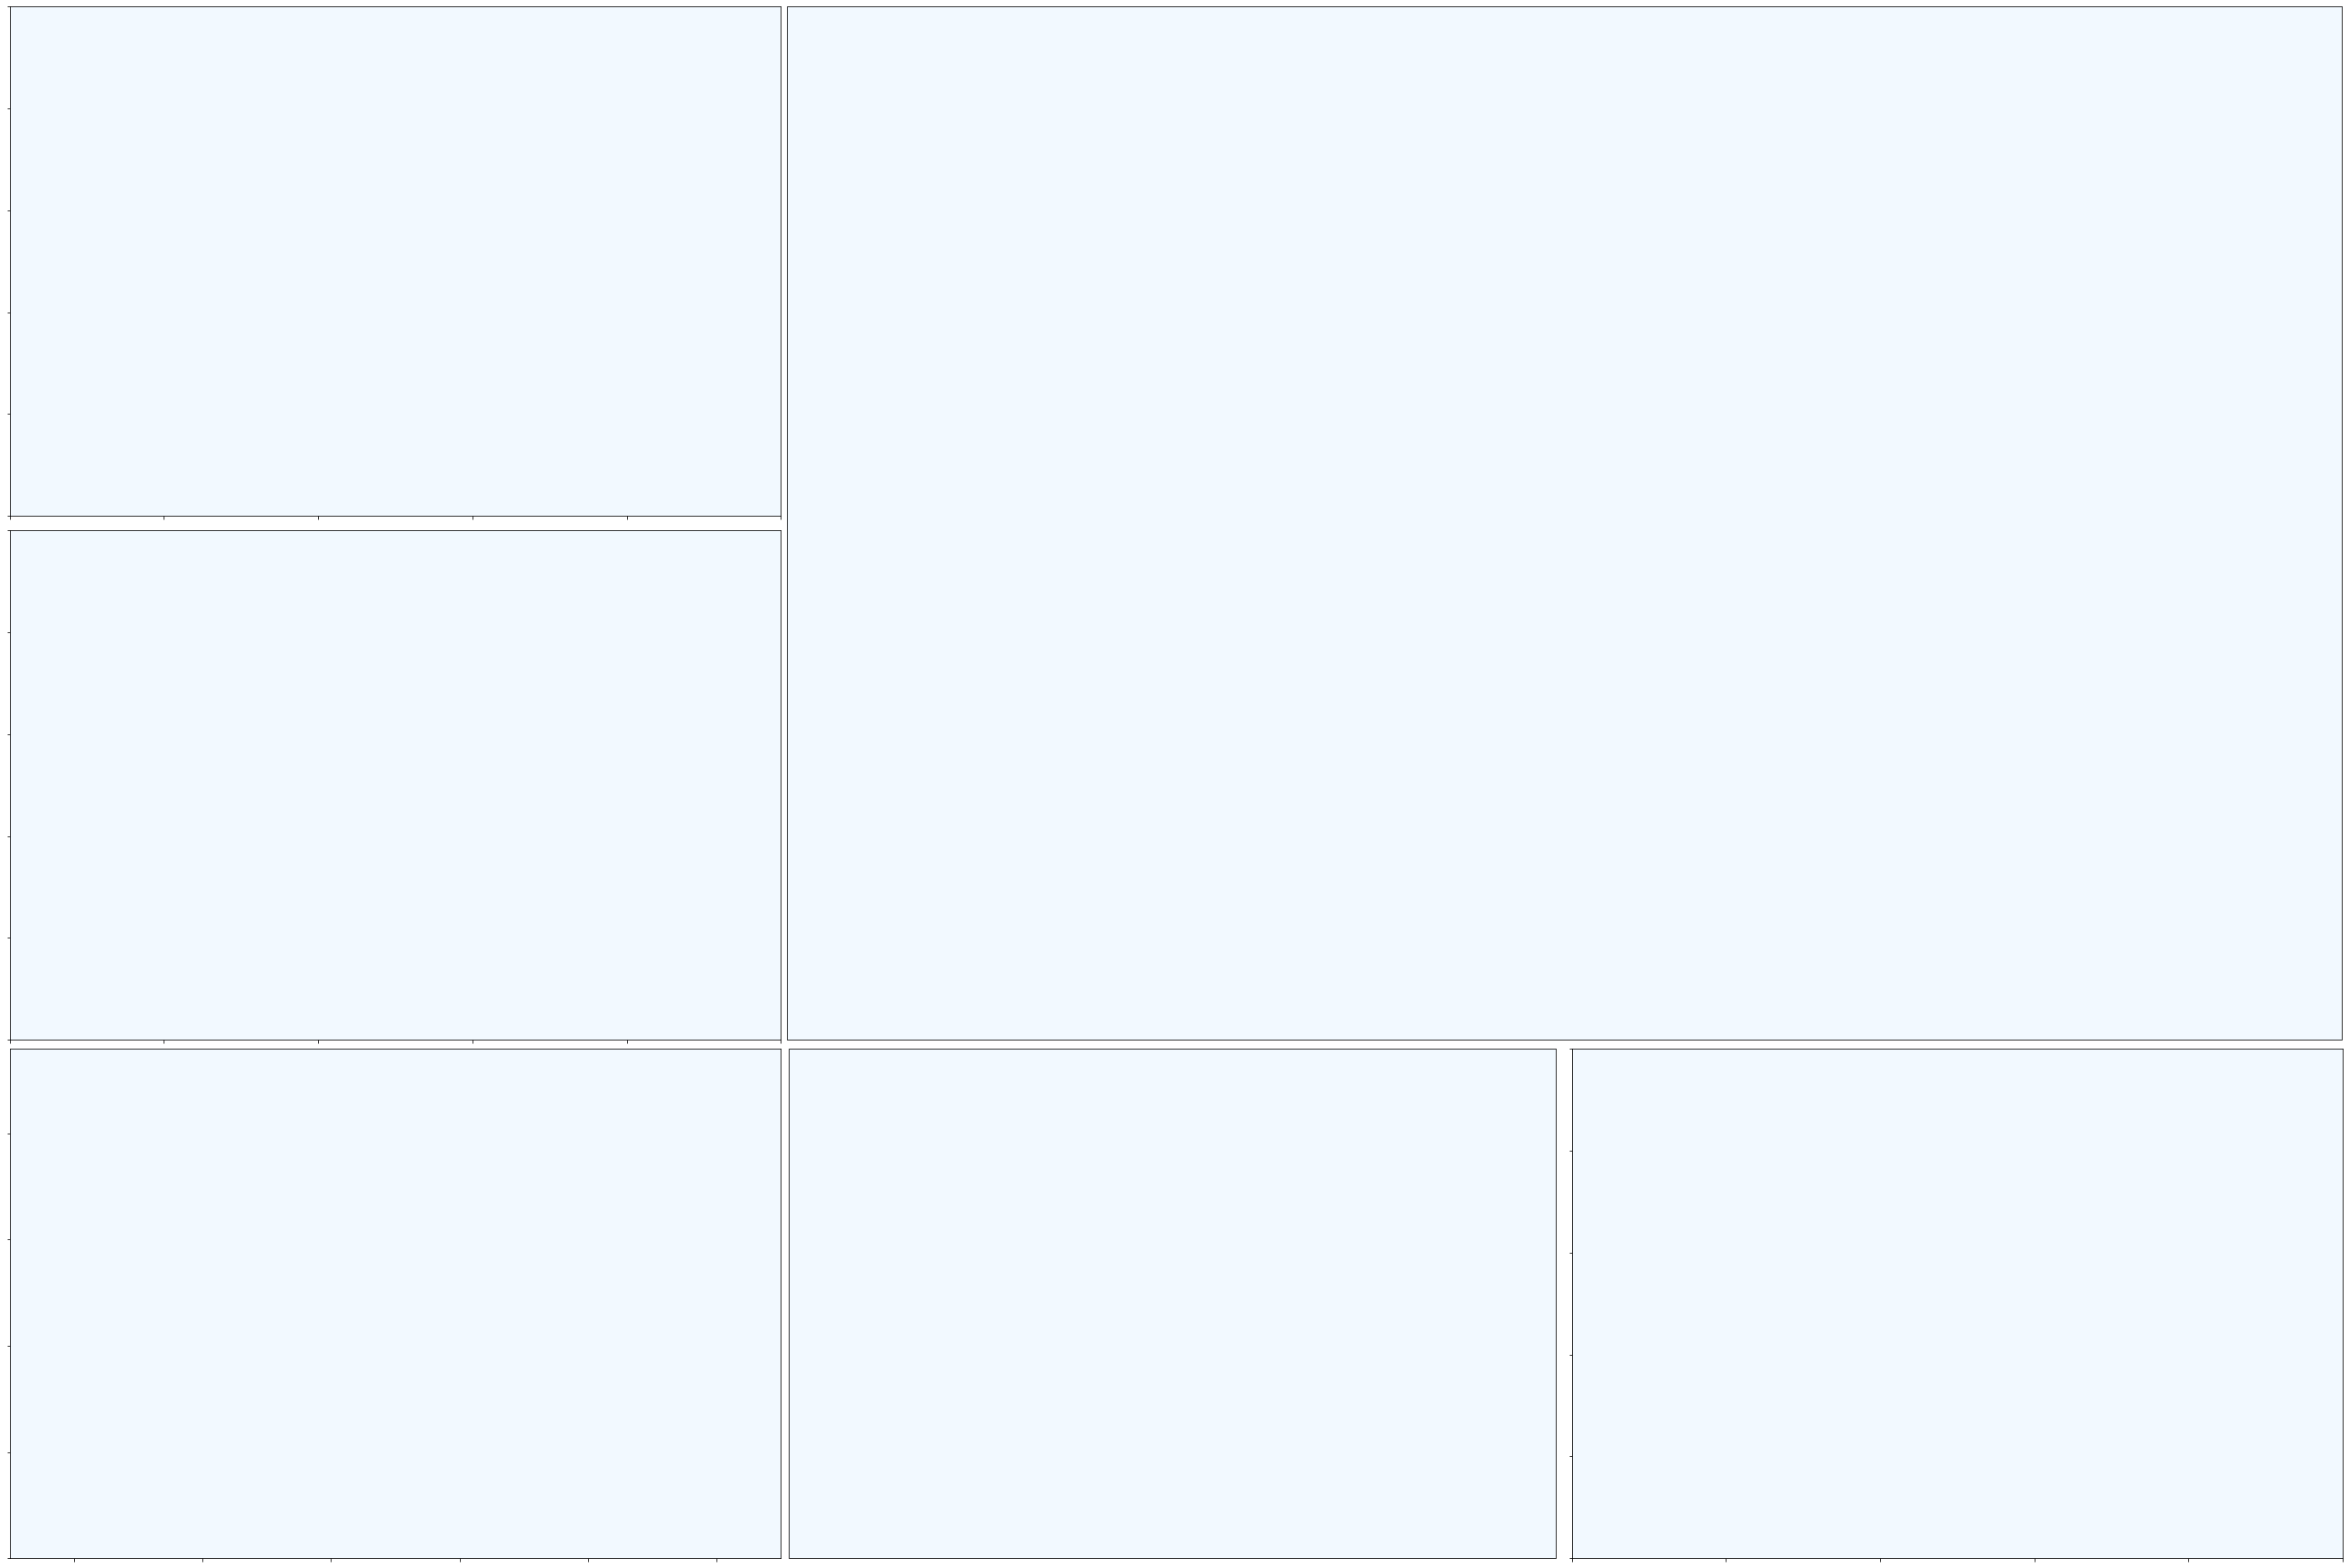

In [4]:
## computations
def process_layout():
    
    ## import needed objects
    from matplotlib.pyplot import figure
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import hsv_to_rgb
    
    ## generate segmented plotting space
    dashboard_figure = figure(
        figsize = (36, 24),
        constrained_layout = True
        )
    fig_grid  = GridSpec(3, 3,
                         figure = dashboard_figure,
                         wspace = 0.00,
                         hspace = 0.00
                        )
    
    ## define non-map plot panels
    axis_explanation = dashboard_figure.add_subplot(fig_grid[0, 0])
    axis_progress    = dashboard_figure.add_subplot(fig_grid[1, 0])
    axis_legend_plus = dashboard_figure.add_subplot(fig_grid[2, 2])
    
    ## define map plot panels
    axis_travels = dashboard_figure.add_subplot(fig_grid[0:2, 1:3],
                        projection = map_projection)
    axis_routes = dashboard_figure.add_subplot(fig_grid[2, 1],
                        projection = map_projection)
    axis_opportunity = dashboard_figure.add_subplot(fig_grid[2, 0])#,
                        #projection = map_projection)  ## FOR TESTING!!
    
    axis_travels.set_extent(map_extent)
    axis_routes.set_extent(map_extent)
        #axis_opportunity.set_extent(map_extent)  ## FOR TESTING!!
    axis_opportunity.set_xlim(-125, -65)
    axis_opportunity.set_ylim(25, 49)
    
    ## package results
    dashboard = {'travels': axis_travels,
                   'explanation': axis_explanation,
                   'routes': axis_routes,
                   'progress': axis_progress,
                   'opportunity': axis_opportunity,
                   'legend_plus': axis_legend_plus}

    for i in dashboard.keys():
        dashboard[i].tick_params(
            labelbottom = False,
            labeltop = False,
            labelleft = False,
            labelright = False
            )
        dashboard[i].set_facecolor( set_color['Background'] )
    
    ## return results
    return dashboard_figure, dashboard

dashboard_figure, dashboard = process_layout()

## display
def display_layout(the_figure):
    the_figure.savefig("C_Output/us_travels.png")
    the_figure.savefig("C_Output/us_travels.pdf")

## test
def test_layout():
    pass

# Non-Map Dashboard Panels

### Explanation: Make explanation / introduction text panel

In [5]:
## text formater helper function
def format_text(x, cl):
    
    ## prepare for text processing
    x = x.split(" ")
    even_lines = [x[0]]
    x = x[1:]
    current_line = 0
    
    ## segment text into lines <= 80 characters
    for i in x:
        if len(even_lines[current_line] + ' ' + i) > cl:
            current_line += 1
            even_lines.append(i)
        else:
            even_lines[current_line] = even_lines[current_line] + ' ' + i
    
    ## combine lines into a single string
    y = str()
    for i in even_lines:
        y = y + '\n' + i
    return y

def loop_format_text(x, char_len):
    y = ''
    for i in x:
        formatted_x = format_text(i, cl = char_len)
        y = y + formatted_x
    return y

## computations
def process_explanation(x = panel_paragraph['explanation']):
    
    ## format text into lines of <= 80 characters
    formatted_text = loop_format_text(x, char_len = 58)
    return formatted_text


## display
def display_explanation(explain):
    dashboard['explanation'].set_xlim(0, 12)
    dashboard['explanation'].set_ylim(0,  8)
    dashboard['explanation'].text(0.1, 0, s = explain,
                                  fontsize = set_font['M'],
                                  color = set_color['Foreground'],
                                  horizontalalignment = 'left',
                                  verticalalignment = 'bottom'
                                 )
    ## title
    dashboard['explanation'].text(0.1, 7.9, 
        s = 'MY TRAVELS IN THE UNITED STATES',
                                  fontsize = set_font['L'],
                                  color = set_color['Foreground'],
                                  horizontalalignment = 'left',
                                  verticalalignment = 'top'
                                 )

## test
def test_explanation():
    pass

## execute
explanation = process_explanation()
display_explanation(explanation)

### Progress: Make horizontal bar charts depicting progress towards city and state travel goals

In [6]:
## computations
def process_progress(x = city_list):
    
    ## identify unvisited cities
    city_list['Unvisit'] = 1 - city_list['Visit']
    
    ## tabulate summary statistics (state_level)
    state_stats = city_list[['State', 'Photo', 'Visit', 'Unvisit']]
    state_stats = state_stats.groupby('State').max().drop(['CAN', 'PR', 'DC'])
    state_stats['Visit'] = state_stats['Visit'] - state_stats['Photo']
    state_stats['Unvisit'] = 1 - (state_stats['Visit'] + state_stats['Photo'])
    state_stats = state_stats.sum()

    ## tabulate summary statistics (city-level)
    city_list['Visit'] = city_list['Visit'] - city_list['Photo']
    city_stats = city_list[['Photo', 'Visit', 'Unvisit']].sum()
    
    ## package and return data
    y = pd.DataFrame({
        'City': city_stats,
        'State': state_stats
    })
    y = pd.melt(y, ignore_index = False).reset_index()
    y.columns = ['Status', 'Entity', 'Count']
    return y

## display
def display_progress(x, explain = panel_paragraph['progress']):
    
        ## set useful measurements
    use_measure = {'bar_start': 1.0, 'bar_height': 3 / 5}
    
    ## scale counts to match plotting coordinates
    func = lambda a: np.cumsum(a / sum(a))
    scaled_count = x[['Entity', 'Count']].groupby('Entity')
    scaled_count = scaled_count.transform(func)
    x['X'] = (scaled_count * (4.4 - use_measure['bar_start']))
    del scaled_count, func
    
    ## generate y coordinates
    x['Y'] = (x['Entity'] == 'State').astype(int)
    
    ## render horizontal barplots
    dashboard['progress'].set_xlim(0, 4.5)
    dashboard['progress'].set_ylim( 0 - (1 - use_measure['bar_height']), 2.8)
    for i in ['Unvisit', 'Visit', 'Photo']:
        dashboard['progress'].barh(
            y = x.loc[x['Status'] == i, 'Entity'],
            width = x.loc[x['Status'] == i, 'X'], 
            height = use_measure['bar_height'],
            left = use_measure['bar_start'],
            align = 'edge',
            color = set_color[i]
            )
    ## render bar count labels
    for i in range(x.shape[0]):
        if x['Count'].astype(int)[i] > 3:
            dashboard['progress'].text(
                x = x['X'][i] - 0.01 + use_measure['bar_start'],
                y = x['Y'][i] + 0.02,
                s = x['Count'].astype(int)[i],
                color = set_color['Foreground'],
                fontsize = set_font['S'],
                horizontalalignment = 'right',
                verticalalignment = 'bottom',
                bbox = dict(pad = 0.1, fc = '#FFFFFF88', ec = '#FFFFFF00',
                            boxstyle = 'Round', mutation_aspect = 1.1)
                )
    ## render legend
    dashboard['progress'].legend(
        labels = ['Unvisited', 'Visited', 'Photographed'],
        fontsize = set_font['S']
        )
    ## render title and explanation
    dashboard['progress'].text(0.05, 3 - 0.25, 
        s = 'TITLE GOES HERE',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(0.05, 3.0 - 0.25 - 0.1, 
        s = loop_format_text(panel_paragraph['progress'], 50),
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(
        x = use_measure['bar_start'],
        y = 0.0 + use_measure['bar_height'] / 2,
        s = "PLACEHOLD \nTEXT ",
        verticalalignment = 'center',
        horizontalalignment = 'right',
        fontsize = set_font['M']
    )

## test
def test_progress(x):
    pass

## execute
progress = process_progress()
display_progress(progress)

### Legend Plus: Display table with legend and other information about planned routes

/var/folders/xk/rmkl6dh17jl6zqhzl0ky4b_w0000gp/T/ipykernel_4007/3731968447.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df.loc[:, 'drive_mileage'] = x.astype(int)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


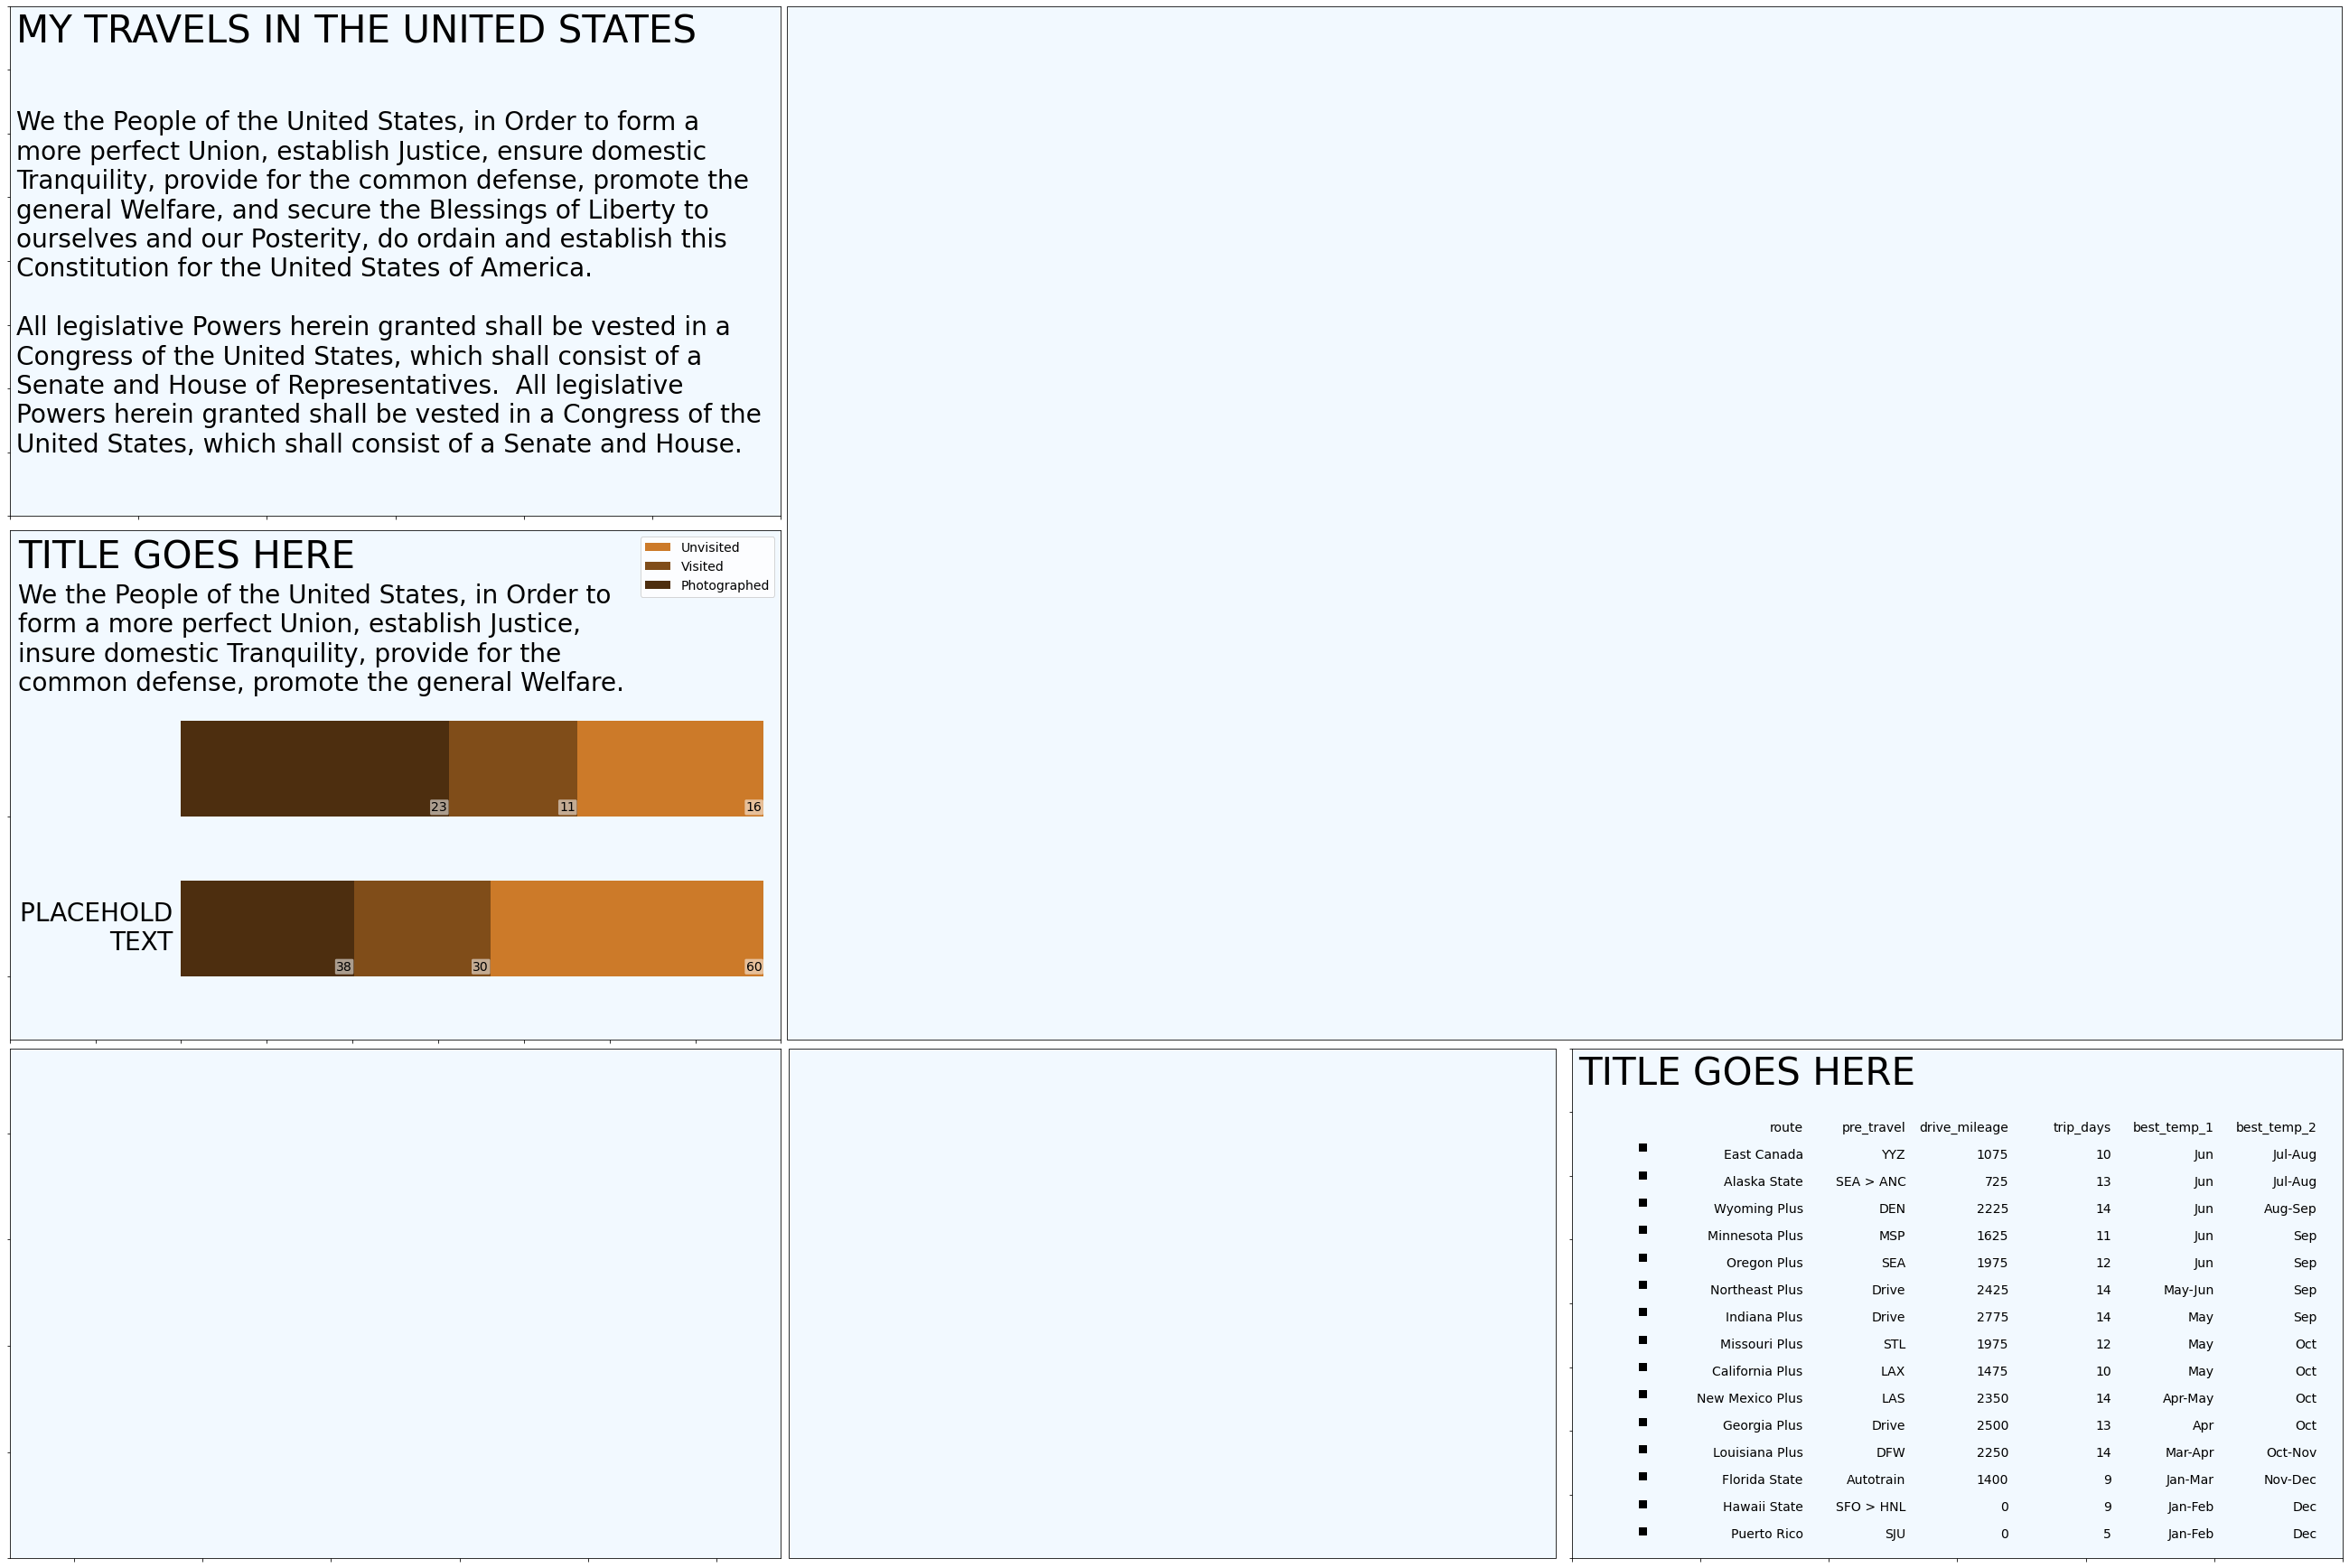

In [7]:
## computations
class LegendTable:
    
    def __init__(self, pd_df):
        x = pd_df['drive_mileage'].values
        x = np.ceil(x / 25) * 25
        pd_df.loc[:, 'drive_mileage'] = x.astype(int)
        del x
        self.table = [list(pd_df.iloc[i]) for i in range(pd_df.shape[0])]
        self.index = pd_df.index
        self.columns = pd_df.columns
        
    def __str__(self):
        print('Columns:')
        for i in self.columns:
            print(i, end = ' ')
        print('\n----')
        for i in self.table:
            print(i)
        return ''


def process_legend_plus(rl = route_list):
    rl = rl[['route', 'pre_travel', 'drive_mileage', 'trip_days',
             'best_temp_1', 'best_temp_2']]
    return LegendTable(rl)
    
## display
def display_legend_plus(rl):
    
    ## set parameters for plot
    dashboard['legend_plus'].set_xlim(0, 12)
    dashboard['legend_plus'].set_ylim(0, 8)
    
    ## render table
    y = dashboard['legend_plus'].table(
        cellText = rl.table,
        rowLabels = None,
        colLabels = rl.columns,
        edges = 'open',
        loc = 'lower right',
        colLoc = 'right'
        )
    y.auto_set_font_size(False)
    y.set_fontsize(set_font['S'])
    y.scale(0.8, 2.5)

    ## title
    dashboard['legend_plus'].text(0.1, 8.0 - 0.1, 
        s = 'TITLE GOES HERE',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    
    ## color key
    dashboard['legend_plus'].scatter(
        [0.1 + 1.00 for i in range(15)],
        [0.43 * (i + 1) for i in range(15)],
        marker = 's',
        s = 60,
        c = set_color['Foreground']
        )
    
    
## test
def test_legend_plus():
    pass

## execute
legend_plus = process_legend_plus()
display_legend_plus(legend_plus)
display_layout(dashboard_figure)

dashboard_figure

# Map Dashboard Panels

### Map: Make the background map underlying the map panels

In [8]:
## computations (not needed so far; keeping stub here just in case)
def process_map():
    pass

## display
def display_map():
    
    ## add coastlines and state borders to plot
    for i in ['travels', 'routes']: # , 'opportunity' ## FOR TESTING!!
        dashboard[i].add_feature(ct.feature.LAND,
                                 lw = 1,
                                 edgecolor = (0, 0, 0, 0),
                                 facecolor = set_color['Land']
                                )
        dashboard[i].add_feature(ct.feature.STATES,
                                    lw = 1,
                                    edgecolor = set_color['Border']
                                   )
        dashboard[i].add_feature(ct.feature.COASTLINE,
                                    lw = 1,
                                    edgecolor = set_color['Coast']
                                   )
    
## test
def test_map():
    pass

## execute
display_map()

### Routes: Map planned routes

In [9]:
## computations (just a stub for now
def process_routes(rt = routes):
    return rt

## display
def display_routes(rt):
    for i in rt.keys():
        dashboard['routes'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
        )

## test
def test_routes():
    pass

routes = process_routes()

display_routes(routes)

### Travels: Map past travels

In [10]:
## computations
def process_travels(x = travels):
    return process_routes(x)

## display
def display_travels(rt):
    for i in rt.keys():
        dashboard['travels'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
        )

## test
def test_travels():
    pass

travels = process_travels()
display_travels(travels)

### Opportunity: Map geographic areas where visit will contribute to goals
+ Kernel density heat map with plasma color scaling

In [11]:
## computations
def process_opportunity(cl = city_list):
    
    ## remove PR, HI, AK from data
    cl = cl[~cl.State.isin(['AK', 'HI', 'PR'])]
    
    ## remove excess precession from data
    cl = cl[['lon', 'lat', 'Score']].round(1).groupby(['lon', 'lat']).sum()
    cl = cl.reset_index()
    
    ## generate data for squares with a score of zero
    full_grid = np.meshgrid(
        np.arange(min(cl.lon), max(cl.lon) + 1, 0.1),
        np.arange(min(cl.lat), max(cl.lat) + 1, 0.1)
        )
    full_grid.append(np.zeros(full_grid[0].shape))
    full_grid[2] = full_grid[2] * np.NaN
    
    ### insert values
    for i in cl.index:
        x = abs(full_grid[0] - cl['lon'][i]) < 0.05
        y = abs(full_grid[1] - cl['lat'][i]) < 0.05
        xy = x * y * cl['Score'][i]
        full_grid[2] = full_grid[2] + xy

    return full_grid
    
    
    
## display
def display_opportunity(op):
    dashboard['opportunity'].contourf(
        op[0], op[1], op[2],
        cmap = 'magma'
        )
    
## test
def test_opportunity():
    pass

## execute
opportunity = process_opportunity()
display_opportunity(opportunity)


## todo: use a distance decay matrix to calculate fuzz

/Users/s8/opt/anaconda3/envs/main/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/s8/opt/anaconda3/envs/main/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


# Finish Rendering Visualization

In [12]:
display_layout(dashboard_figure)
time_check('Z')

Time Check: Point Z
2022-02-20 22:21:25.012108
